In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_with_context.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)
df['divyield_Median'] = df['divyield_Median'].replace('%', '', regex=True).astype(float)

df = df.dropna(subset=['relative_quarterly_return'])


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11761 entries, 0 to 11812
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           11761 non-null  int64         
 1   gvkey                           11761 non-null  int64         
 2   datadate                        11761 non-null  datetime64[ns]
 3   tic                             11761 non-null  object        
 4   actq                            11761 non-null  float64       
 5   ancq                            11761 non-null  float64       
 6   epsfxq                          11748 non-null  float64       
 7   lctq                            11761 non-null  float64       
 8   ltq                             11761 non-null  float64       
 9   revtq                           11761 non-null  float64       
 10  capxy                           11295 non-null  float64       
 11  pr

In [3]:
df = df.loc[:, df.count() >= 11000]

# Drop rows with missing values
df = df.dropna()

# Display dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9795 entries, 73 to 11812
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           9795 non-null   int64         
 1   gvkey                           9795 non-null   int64         
 2   datadate                        9795 non-null   datetime64[ns]
 3   tic                             9795 non-null   object        
 4   actq                            9795 non-null   float64       
 5   ancq                            9795 non-null   float64       
 6   epsfxq                          9795 non-null   float64       
 7   lctq                            9795 non-null   float64       
 8   ltq                             9795 non-null   float64       
 9   revtq                           9795 non-null   float64       
 10  capxy                           9795 non-null   float64       
 11  pr

In [4]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 76
['F' 'CVX' 'OXY' 'COP' 'XOM' 'BMY' 'ABT' 'PFE' 'MRK' 'JNJ' 'GE' 'MMM'
 'CAT' 'RTX' 'CL' 'PG' 'WBA' 'KO' 'CVS' 'PPL' 'ADM' 'APD' 'SPGI' 'BAX'
 'IBM' 'MCD' 'DIS' 'EXC' 'LMT' 'NOC' 'BA' 'MMC' 'LLY' 'ECL' 'LUV' 'INTC'
 'TMO' 'WDC' 'TSN' 'BRK.B' 'AAPL' 'KMB' 'RJF' 'AMD' 'AFL' 'VZ' 'T' 'UNH'
 'PGR' 'MSFT' 'MS' 'SCHW' 'HCA' 'REGN' 'QCOM' 'SBUX' 'JPM' 'WFC' 'AIG'
 'AMZN' 'AMT' 'EXPE' 'UPS' 'EQIX' 'NFLX' 'CME' 'GOOGL' 'FIS' 'MA' 'V' 'GS'
 'TSLA' 'META' 'ZTS' 'CTSH' 'PYPL']


In [5]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.info()

Number of unique gvkeys: 76
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9795 entries, 73 to 11812
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           9795 non-null   int64         
 1   gvkey                           9795 non-null   int64         
 2   datadate                        9795 non-null   datetime64[ns]
 3   tic                             9795 non-null   object        
 4   actq                            9795 non-null   float64       
 5   ancq                            9795 non-null   float64       
 6   epsfxq                          9795 non-null   float64       
 7   lctq                            9795 non-null   float64       
 8   ltq                             9795 non-null   float64       
 9   revtq                           9795 non-null   float64       
 10  capxy                           9795 non-n

In [6]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

#df = df[~df['tic'].isin(tickers_to_drop)]

In [7]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

df = df.sort_values(by=['datadate'])

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

test_df = test_df.sort_values(by=['datadate', 'next_prccq_change'], ascending=[True, False])
test_df.head(10)


,index,gvkey,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,...,de_ratio_Median,debt_ebitda_Median,debt_assets_Median,intcov_ratio_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,rect_turn_Median
9757,11660,184996,2013-03-31,TSLA,0.002334,0.048120,-1.000000,-0.006464,-0.014447,0.833932,...,0.830,0.762,0.479,7.075,0.469,2.214,1.392,1.212,5.458,6.845
9805,11619,1161,2013-03-31,AMD,0.032230,-0.159078,-0.698413,-0.054402,-0.023108,-0.058009,...,4.466,2.521,0.823,5.217,0.540,1.654,1.523,0.187,2.317,1.304
9781,11666,23812,2013-03-31,REGN,0.083838,0.107948,-0.779412,0.206017,0.041366,0.060448,...,0.502,0.000,0.373,0.737,2.225,3.458,3.022,0.602,2.994,6.400
9820,11663,149070,2013-03-31,CME,0.410638,-0.000707,0.420000,0.547441,0.197396,0.087305,...,4.466,2.521,0.823,5.217,0.540,1.654,1.523,0.187,2.317,1.304
9769,11649,11399,2013-03-31,WDC,0.022997,-0.024726,0.176471,-0.030066,-0.031327,-0.015690,...,0.580,0.046,0.376,5.823,1.139,2.450,2.035,0.795,4.363,6.177
9765,11628,12141,2013-03-31,MSFT,0.044098,0.037638,-0.052632,0.000595,0.023348,-0.045069,...,0.580,0.046,0.376,5.823,1.139,2.450,2.035,0.795,4.363,6.177
9821,11667,13988,2013-03-31,SCHW,0.000000,0.000000,0.000000,0.000000,-0.004031,0.032761,...,4.466,2.521,0.823,5.217,0.540,1.654,1.523,0.187,2.317,1.304
9785,11615,2285,2013-03-31,BA,0.038057,-0.019945,0.125000,0.015206,-0.000506,-0.152856,...,0.954,1.417,0.514,8.063,0.453,2.362,1.458,1.037,4.677,6.859
9784,11613,7985,2013-03-31,NOC,-0.065062,-0.004573,-0.051402,-0.082728,-0.034294,-0.057443,...,0.954,1.417,0.514,8.063,0.453,2.362,1.458,1.037,4.677,6.859
9756,11636,4839,2013-03-31,F,0.000000,0.000000,0.000000,0.000000,0.004620,-0.002295,...,0.830,0.762,0.479,7.075,0.469,2.214,1.392,1.212,5.458,6.845


In [8]:
# Create a copy of the test results
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

# Define columns to drop
drop_cols = ['gvkey', 'datadate', 'tic', 'spindx', 'spindx_change', 'next_spindx_change', 'prccq', 'prccq_change', 'next_prccq_change', 'FFI10_desc']

# Drop the specified columns from train, validation, and test datasets
train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

# Display the first few rows of the training dataset
train_df.head()

,index,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,...,de_ratio_Median,debt_ebitda_Median,debt_assets_Median,intcov_ratio_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,rect_turn_Median
73,169,0.0,0.0,-0.558442,0.0,0.0,-0.128180,0.0,0.211,0.089,...,0.828,1.436,0.468,6.364,0.221,2.371,1.157,1.652,3.700,7.404
80,158,0.0,0.0,0.259259,0.0,0.0,0.098502,0.0,0.231,0.113,...,0.562,0.765,0.362,16.601,0.392,2.395,1.520,1.281,2.598,6.677
85,163,0.0,0.0,0.011905,0.0,0.0,0.007580,0.0,0.334,0.137,...,0.777,1.549,0.444,6.242,0.218,2.438,1.239,1.348,3.922,6.718
84,155,0.0,0.0,0.064220,0.0,0.0,-0.008542,0.0,0.144,0.071,...,0.777,1.549,0.444,6.242,0.218,2.438,1.239,1.348,3.922,6.718
82,174,0.0,0.0,0.078947,0.0,0.0,0.017200,0.0,0.250,0.133,...,0.562,0.765,0.362,16.601,0.392,2.395,1.520,1.281,2.598,6.677


In [9]:
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return',], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return',], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return',], 1)

X_train.head()

,index,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,...,de_ratio_Median,debt_ebitda_Median,debt_assets_Median,intcov_ratio_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,rect_turn_Median
73,169,0.0,0.0,-0.558442,0.0,0.0,-0.128180,0.0,0.211,0.089,...,0.828,1.436,0.468,6.364,0.221,2.371,1.157,1.652,3.700,7.404
80,158,0.0,0.0,0.259259,0.0,0.0,0.098502,0.0,0.231,0.113,...,0.562,0.765,0.362,16.601,0.392,2.395,1.520,1.281,2.598,6.677
85,163,0.0,0.0,0.011905,0.0,0.0,0.007580,0.0,0.334,0.137,...,0.777,1.549,0.444,6.242,0.218,2.438,1.239,1.348,3.922,6.718
84,155,0.0,0.0,0.064220,0.0,0.0,-0.008542,0.0,0.144,0.071,...,0.777,1.549,0.444,6.242,0.218,2.438,1.239,1.348,3.922,6.718
82,174,0.0,0.0,0.078947,0.0,0.0,0.017200,0.0,0.250,0.133,...,0.562,0.765,0.362,16.601,0.392,2.395,1.520,1.281,2.598,6.677


In [10]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,index,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,...,de_ratio_Median,debt_ebitda_Median,debt_assets_Median,intcov_ratio_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,rect_turn_Median
0,0.001544,0.043707,0.073945,0.355617,0.079621,0.103624,0.062601,0.046753,0.825456,0.935125,...,0.096684,0.298049,0.352066,0.540406,0.063956,0.485576,0.230519,0.661739,0.051645,0.237601
1,0.000482,0.043707,0.073945,0.357851,0.079621,0.103624,0.072060,0.046753,0.831634,0.936027,...,0.047131,0.158780,0.176860,1.000000,0.127172,0.492431,0.348377,0.500435,0.006151,0.211472
2,0.000965,0.043707,0.073945,0.357175,0.079621,0.103624,0.068266,0.046753,0.863454,0.936929,...,0.087183,0.321503,0.312397,0.534929,0.062847,0.504713,0.257143,0.529565,0.060810,0.212946
3,0.000193,0.043707,0.073945,0.357318,0.079621,0.103624,0.067593,0.046753,0.804757,0.934448,...,0.087183,0.321503,0.312397,0.534929,0.062847,0.504713,0.257143,0.529565,0.060810,0.212946
4,0.002026,0.043707,0.073945,0.357359,0.079621,0.103624,0.068668,0.046753,0.837504,0.936779,...,0.047131,0.158780,0.176860,1.000000,0.127172,0.492431,0.348377,0.500435,0.006151,0.211472


In [11]:

context = ['relative_quarterly_return_-1', 'relative_quarterly_return_-2', 'relative_quarterly_return_-3', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'indret_ew', 'CAPEI_Median', 'bm_Median', 'evm_Median', 'pe_inc_Median', 'ptb_Median', 'PEG_trailing_Median', 'divyield_Median', 'roa_Median', 'roce_Median', 'roe_Median', 'gpm_Median', 'npm_Median', 'opmad_Median', 'de_ratio_Median', 'debt_ebitda_Median', 'debt_assets_Median', 'intcov_ratio_Median', 'cash_ratio_Median', 'curr_ratio_Median', 'quick_ratio_Median', 'at_turn_Median', 'inv_turn_Median', 'rect_turn_Median']

C_train = X_train_scaled[context].to_numpy()
C_valid = X_valid_scaled[context].to_numpy()
C_test = X_test_scaled[context].to_numpy()

X_train_context = X_train_scaled.drop(columns=context)
X_valid_context = X_valid_scaled.drop(columns=context)
X_test_context = X_test_scaled.drop(columns=context)


In [12]:


%%time

parameters = {
    'n_estimators': [300,200],
    'learning_rate': [0.1],
    'max_depth': [8,10,12],
    'gamma': [0.5,1],
    'random_state': [42]
}

eval_set = [(X_train_context, y_train), (X_test_context, y_test)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_context, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:06:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:06:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:06:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:06:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.16817027798138703
CPU times: user 1min 37s, sys: 4.21 s, total: 1min 41s
Wall time: 16.5 s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.




In [13]:

%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_context, y_train, eval_set=eval_set, verbose=False)



CPU times: user 2.49 s, sys: 114 ms, total: 2.61 s
Wall time: 414 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

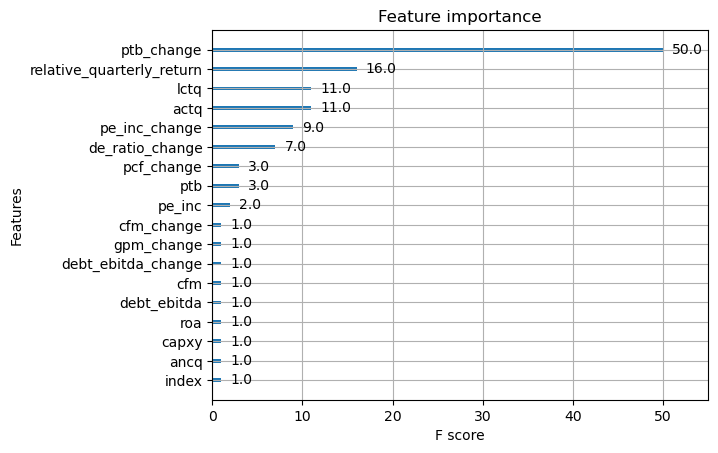

In [14]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [15]:
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_test_binary, y_test_pred_binary))



ValueError: feature_names mismatch: ['index', 'actq', 'ancq', 'epsfxq', 'lctq', 'ltq', 'revtq', 'capxy', 'roa', 'roe', 'pe_inc', 'pcf', 'roce', 'debt_ebitda', 'gpm', 'evm', 'cfm', 'npm', 'de_ratio', 'ptb', 'roa_change', 'roe_change', 'pe_inc_change', 'pcf_change', 'roce_change', 'debt_ebitda_change', 'gpm_change', 'evm_change', 'cfm_change', 'npm_change', 'de_ratio_change', 'ptb_change', 'relative_quarterly_return'] ['index', 'actq', 'ancq', 'epsfxq', 'lctq', 'ltq', 'revtq', 'capxy', 'roa', 'roe', 'pe_inc', 'pcf', 'roce', 'debt_ebitda', 'gpm', 'evm', 'cfm', 'npm', 'de_ratio', 'ptb', 'roa_change', 'roe_change', 'pe_inc_change', 'pcf_change', 'roce_change', 'debt_ebitda_change', 'gpm_change', 'evm_change', 'cfm_change', 'npm_change', 'de_ratio_change', 'ptb_change', 'relative_quarterly_return', 'relative_quarterly_return_-1', 'relative_quarterly_return_-2', 'relative_quarterly_return_-3', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'indret_ew', 'CAPEI_Median', 'bm_Median', 'evm_Median', 'pe_inc_Median', 'ptb_Median', 'PEG_trailing_Median', 'divyield_Median', 'roa_Median', 'roce_Median', 'roe_Median', 'gpm_Median', 'npm_Median', 'opmad_Median', 'de_ratio_Median', 'debt_ebitda_Median', 'debt_assets_Median', 'intcov_ratio_Median', 'cash_ratio_Median', 'curr_ratio_Median', 'quick_ratio_Median', 'at_turn_Median', 'inv_turn_Median', 'rect_turn_Median']
training data did not have the following fields: h_1_y, roce_Median, inv_turn_Median, de_ratio_Median, r_ia, indret_ew, r_f, PEG_trailing_Median, opmad_Median, hml, relative_quarterly_return_-1, roe_Median, gpm_Median, rf, debt_assets_Median, quick_ratio_Median, npm_Median, r_eg, h_3_y, roa_Median, ptb_Median, relative_quarterly_return_-2, r_mkt, umd, CAPEI_Median, r_roe, rect_turn_Median, debt_ebitda_Median, bm_Median, h_1_x, smb, evm_Median, rmw, h_3_x, h_12_y, r_me, pe_inc_Median, cash_ratio_Median, h_12_x, at_turn_Median, intcov_ratio_Median, cma, divyield_Median, curr_ratio_Median, mktrf, relative_quarterly_return_-3

In [ ]:
results['y_pred'] = y_test_pred
results1 = results.sort_values(by=['datadate', 'y_pred'], ascending=[True, False])

results1.head(10)



,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred
9805,2013-03-31,AMD,0.600000,0.566207,0.369017
9774,2013-03-31,ABT,-0.012458,-0.046250,0.215635
9781,2013-03-31,REGN,0.274808,0.241016,0.136792
9769,2013-03-31,WDC,0.234639,0.200846,0.136792
9780,2013-03-31,BMY,0.084972,0.051179,0.118884
9784,2013-03-31,NOC,0.180328,0.146535,0.117401
9789,2013-03-31,LMT,0.123705,0.089912,0.097858
9811,2013-03-31,BRK.B,0.074088,0.040296,0.097858
9757,2013-03-31,TSLA,1.833465,1.799673,0.093781
9804,2013-03-31,LUV,-0.043769,-0.077561,0.079407


In [ ]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.5):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()


# Baseline aggregation remains unchanged.
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the ideal top 10, weight by the actual returns
df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the ideal bottom 10, weight by the actual returns
df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,62,0.083195,0.322333,0.959119,-0.004228,-0.123643
1,2013-06-30,61,0.068066,0.282144,0.615021,-0.024151,-0.093581
2,2013-09-30,63,0.104675,0.145975,0.315112,-0.101912,-0.137854
3,2013-12-31,63,0.034818,0.209945,0.302349,-0.034142,-0.116466
4,2014-03-31,66,0.032713,0.049979,0.218498,-0.114162,-0.251419
5,2014-06-30,66,0.025379,0.137001,0.228289,-0.048830,-0.141806
6,2014-09-30,65,0.036710,0.135638,0.210748,-0.143552,-0.197616
7,2014-12-31,65,0.010804,0.028237,0.192479,-0.028401,-0.153323
8,2015-03-31,66,0.016184,0.079843,0.385555,-0.134337,-0.172890
9,2015-06-30,66,-0.057124,0.064734,0.160524,-0.265512,-0.355343


In [ ]:
for portfolio in ['baseline', 'top_10', 'bottom_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.028784807352579378
Sharpe Ratio of the baseline portfolio: 0.05933810083202336

Mean quarterly return of the top_10 portfolio: 0.1292717322216929
Sharpe Ratio of the top_10 portfolio: 1.2853242267036853

Mean quarterly return of the bottom_10 portfolio: -0.06324823609413971
Sharpe Ratio of the bottom_10 portfolio: -1.1820962158254187



In [ ]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()


In [ ]:
train_df = train_df[important_features + ['next_relative_quarterly_return']]
valid_df = valid_df[important_features + ['next_relative_quarterly_return']]
test_df  = test_df[important_features + ['next_relative_quarterly_return']]

y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return'], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return'], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return'], 1)

# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,ptb_change,lctq,pe_inc_change,relative_quarterly_return_-2,relative_quarterly_return_-3
0,0.029268,0.079621,0.526691,0.150910,0.122505
1,0.029442,0.079621,0.526682,0.134719,0.167161
2,0.028297,0.079621,0.526692,0.124914,0.131971
3,0.031425,0.079621,0.526997,0.124646,0.115688
4,0.033927,0.079621,0.527082,0.109415,0.178258


In [ ]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0.1,
    'random_state': 42
}
eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]


model = xgb.XGBRegressor(**params)
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_test_binary, y_test_pred_binary))


[ 0.12628354  0.5056621   0.30334368 ... -0.04682929 -0.07298326
 -0.04122842]
              precision    recall  f1-score   support

           0       0.71      0.50      0.59       885
           1       0.63      0.81      0.71       918

    accuracy                           0.66      1803
   macro avg       0.67      0.66      0.65      1803
weighted avg       0.67      0.66      0.65      1803



In [ ]:
results['y_pred_import'] = y_test_pred
results = results.sort_values(by=['datadate', 'y_pred'], ascending=[True, False])

results.head(5)

,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred,y_pred_import
9805,2013-03-31,AMD,0.600000,0.566207,0.369017,0.505662
9774,2013-03-31,ABT,-0.012458,-0.046250,0.215635,0.106045
9781,2013-03-31,REGN,0.274808,0.241016,0.136792,0.303344
9769,2013-03-31,WDC,0.234639,0.200846,0.136792,0.143451
9780,2013-03-31,BMY,0.084972,0.051179,0.118884,0.085315


In [ ]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.5):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_import'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred_import',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_import'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred_import',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(10)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal,baseline_cum_return,top_10_cum_return,baseline_value,top_10_value,top_10_import,bottom_10_import
0,2013-03-31,62,0.083195,0.322333,0.959119,-0.004228,-0.123643,1.083195,1.322333,1083.195228,1322.333329,0.411161,-0.038580
1,2013-06-30,61,0.068066,0.282144,0.615021,-0.024151,-0.093581,1.156924,1.695422,1156.924080,1695.421650,0.290635,-0.028582
2,2013-09-30,63,0.104675,0.145975,0.315112,-0.101912,-0.137854,1.278025,1.942910,1278.024640,1942.910319,0.160877,-0.011916
3,2013-12-31,63,0.034818,0.209945,0.302349,-0.034142,-0.116466,1.322523,2.350815,1322.523473,2350.814964,0.172506,-0.048153
4,2014-03-31,66,0.032713,0.049979,0.218498,-0.114162,-0.251419,1.365787,2.468307,1365.787214,2468.306595,0.036836,-0.147125
5,2014-06-30,66,0.025379,0.137001,0.228289,-0.048830,-0.141806,1.400449,2.806467,1400.449084,2806.466782,0.100721,-0.048155
6,2014-09-30,65,0.036710,0.135638,0.210748,-0.143552,-0.197616,1.451860,3.187129,1451.859929,3187.128989,0.165213,-0.159455
7,2014-12-31,65,0.010804,0.028237,0.192479,-0.028401,-0.153323,1.467546,3.277122,1467.545884,3277.122476,0.058115,-0.038896
8,2015-03-31,66,0.016184,0.079843,0.385555,-0.134337,-0.172890,1.491297,3.538777,1491.296756,3538.777304,0.328293,-0.103840
9,2015-06-30,66,-0.057124,0.064734,0.160524,-0.265512,-0.355343,1.406108,3.767856,1406.107690,3767.855607,0.097730,-0.287713


In [ ]:
for portfolio in ['top_10', 'top_10_import']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the top_10 portfolio: 0.1292717322216929
Sharpe Ratio of the top_10 portfolio: 1.2853242267036853

Mean quarterly return of the top_10_import portfolio: 0.15858763907865986
Sharpe Ratio of the top_10_import portfolio: 1.0847068688778776

